In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import random
import optuna
import os

from joblib import dump
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from optuna.samplers import TPESampler

# CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE.type

# Fix random seed
seed = 42
torch.manual_seed(seed)
if DEVICE.type == 'cuda':
	torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

# Pre-processing input data

In [2]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')

target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 3.7178027629852295 | std error: 10.728959083557129

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

if DEVICE.type == 'cuda':
	X_train = X_train.to(DEVICE)
	y_train = y_train.to(DEVICE)
	X_test = X_test.to(DEVICE)
	y_test = y_test.to(DEVICE)

In [3]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: Feedforward Neural Network

In [4]:
class History:
	def __init__(self):
		self.loss = []
		self.val_loss = []
	
	def append(self, loss, val_loss):
		self.loss.append(loss)
		self.val_loss.append(val_loss)

def inv_scaling(y, y_scaler, d=False):
    if d:
        return y_scaler.inverse_transform(y.detach().cpu().numpy().reshape(-1, 1))
    return y_scaler.inverse_transform(y.cpu().numpy().reshape(-1, 1))

In [5]:
class FeedforwardModel(nn.Module):
	def __init__(self, input_dim, dropout=0.1):
		super(FeedforwardModel, self).__init__()
		# layers
		self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
			nn.Linear(64, 32),
			nn.ReLU(),
			nn.Dropout(p=dropout),
            nn.Linear(32, 1),
        )
	
	def forward(self, x):
		return self.model(x)
	
	def fit(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, learning_rate=0.0002, verbose=True, patience=10):
		train_data = TensorDataset(X_train, y_train)
		test_data = TensorDataset(X_test, y_test)
		train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
		test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

		best_val_loss = np.inf
		epoch_no_improve = 0
		best_model_state = None
		optimizer = optim.Adam(self.parameters(), lr=learning_rate)
		criterion = nn.MSELoss()
		history = History()

		for epoch in range(epochs):
			self.train()
			total_loss = 0
			for batch_X, batch_y in train_loader:
				optimizer.zero_grad()
				output = self(batch_X)
				loss = torch.sqrt(criterion(output, batch_y))
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			avg_loss = total_loss / len(train_loader)

			self.eval()
			total_val_loss = 0
			with torch.no_grad():
				for batch_X, batch_y in test_loader:
					output = self(batch_X)
					val_loss = torch.sqrt(criterion(output, batch_y))
					total_val_loss += val_loss.item()
				avg_val_loss = total_val_loss / len(test_loader)
			
			if verbose:
				print(f"Epoch: {epoch+1} - Loss: {avg_loss} - Val Loss: {avg_val_loss}")

			# Early stopping
			if avg_val_loss < best_val_loss:
				best_val_loss = avg_val_loss
				best_model_state = self.state_dict()
				epoch_no_improve = 0
			else:
				epoch_no_improve += 1
				if epoch_no_improve >= patience:
					print(f"Early stopping at epoch {epoch+1}")
					break
			history.append(avg_loss, avg_val_loss)
		
		if best_model_state is not None:
			self.load_state_dict(best_model_state)
		
		return history

	def predict(model, X):
		model.eval()
		with torch.no_grad():
			prediction = torch.nn.functional.relu(model(X))
		return prediction

# Hyperparameters Optimization

In [6]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, input_dim):
	dropout = trial.suggest_float('dropout', 0.1, 0.5)
	learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
	num_epochs = trial.suggest_int('num_epochs', 10, 100)

	# Model initialization 
	model = FeedforwardModel(input_dim, dropout)
	if DEVICE.type == 'cuda':
		model = model.to(DEVICE)
	# Fit model
	history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=learning_rate)
	loss = history.loss[-1]
	val_loss = history.val_loss[-1]
	print(f"Trial: {trial.number} - RMSE Loss: {loss} - RMSE Val Loss: {val_loss} - epochs: {len(history.loss)}")
	return val_loss.item()

n_trials = 250
study = None

In [7]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, len(features)), n_trials=n_trials)

In [8]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [9]:
# hyperparameters
if study is not None:
	dropout = study.best_trial.params['dropout']
	lr = study.best_trial.params['learning_rate']
	num_epochs = study.best_trial.params['num_epochs']
else:
	dropout = 0.1
	lr = 0.0002
	num_epochs = 100

In [10]:
# Model initialization
model = FeedforwardModel(len(features), dropout)
if DEVICE.type == 'cuda':
	model = model.to(DEVICE)
# Fit model
history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=lr)
loss = history.loss[-1]
val_loss = history.val_loss[-1]

Epoch: 1 - Loss: 0.07165611523222189 - Val Loss: 0.02191117390268583
Epoch: 2 - Loss: 0.037777387426754086 - Val Loss: 0.019098554435992426
Epoch: 3 - Loss: 0.033502418132828275 - Val Loss: 0.016564483110272844
Epoch: 4 - Loss: 0.030959705804540636 - Val Loss: 0.018234483265717114
Epoch: 5 - Loss: 0.029400464244541475 - Val Loss: 0.014780558520742566
Epoch: 6 - Loss: 0.028220366783291023 - Val Loss: 0.012464934705002676
Epoch: 7 - Loss: 0.027819185206951678 - Val Loss: 0.012670612851161816
Epoch: 8 - Loss: 0.026979285682183364 - Val Loss: 0.011848207004771474
Epoch: 9 - Loss: 0.026660531244491036 - Val Loss: 0.011421049359452092
Epoch: 10 - Loss: 0.026207769025679277 - Val Loss: 0.010882810056028138
Epoch: 11 - Loss: 0.025951159154425092 - Val Loss: 0.010757435455886059
Epoch: 12 - Loss: 0.025722695031521157 - Val Loss: 0.010862117143120069
Epoch: 13 - Loss: 0.025385061483941027 - Val Loss: 0.012762209719542849
Epoch: 14 - Loss: 0.025324734219482392 - Val Loss: 0.011405794629555002
Epo

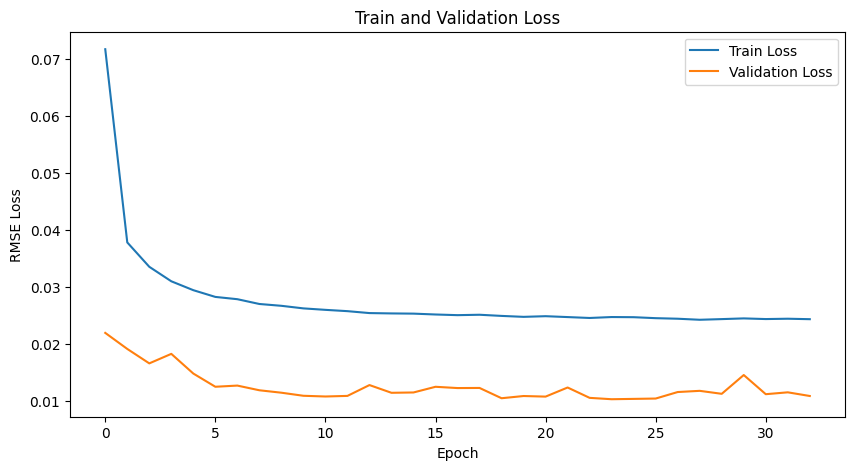

In [11]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.loss, label='Train Loss')
plt.plot(history.val_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [12]:
# save model
torch.save(model, '../models/feedforward_model.pt')

# Describe Validation

In [10]:
model = torch.load('../models/feedforward_model.pt').to(DEVICE)

In [11]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = model.predict(X)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [12]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [ ]:
_, _, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
df = pd.DataFrame(predictions, columns=['predictions'])
df['actual'] = y_scaled
df.to_csv('csv/predictions_feedforward.csv', index=False)

In [13]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 23.594276428222656 | Std actual: 45.070960998535156
Mean actual: 23.631031036376953 | Std actual: 41.60096740722656
Mean Error: 2.088689088821411 | Std Error: 6.057078838348389
Min instance
total_time                                                            5.28
total_cpu_usage                                                       0.99
max_ram_usage                                                    26.308594
brand_raw                         Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                 GenuineIntel
arch                                                                X86_64
count                                                                   12
l2_cache_size                                                          1.5
l3_cache_size                                                         12.0
l2_cache_line_size                                                     256
l2_cache

In [17]:
# get index of total_time_target of pcs that are not in train set
index = test_df_og[test_df_og['brand_raw_target'].isin(['Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz','Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz'])].index
X_test_notrainpc = X_test[index]
y_test_notrainpc = y_test[index]
test_df_og_notrainpc = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_notrainpc, y_test_notrainpc, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_notrainpc, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target > 150.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_notrainpc.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_notrainpc.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target > 150.0
Mean prediction: 17.287107467651367 | Std actual: 2.6013660430908203
Mean actual: 20.84064292907715 | Std actual: 3.445856809616089
Mean Error: 3.5761239528656006 | Std Error: 2.3790314197540283
Min instance
total_time                                                             20.0
total_cpu_usage                                                        0.99
max_ram_usage                                                     15.179688
brand_raw                         Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           3.0
l3_cache_size                                                          20.0
l2_cache_line_size                        

# SHAP Analysis

In [20]:
y_prediction = np.expm1(inv_scaling(model.predict(X_test[::30]), y_scaler))
test_df_og = test_df_og[::30]

In [21]:
import shap
train_random_indices = np.random.choice(X_train.shape[0], 2500, replace=False)
X_train_random = X_train[train_random_indices]
explainer = shap.DeepExplainer(model, X_train_random)
shap_values = explainer.shap_values(X_test[::30])
X_test_non_scaled = x_scaler.inverse_transform(X_test[::30].cpu().numpy())
X_test_non_scaled[:, 0] = np.expm1(X_test_non_scaled[:, 0])
shap.initjs()

In [22]:
shap.force_plot(explainer.expected_value[0], shap_values[:, :, 0], X_test_non_scaled, feature_names=features)

Prediction: 0.3253369927406311 | Actual: 0.36 | Error: 0.03466300725936888


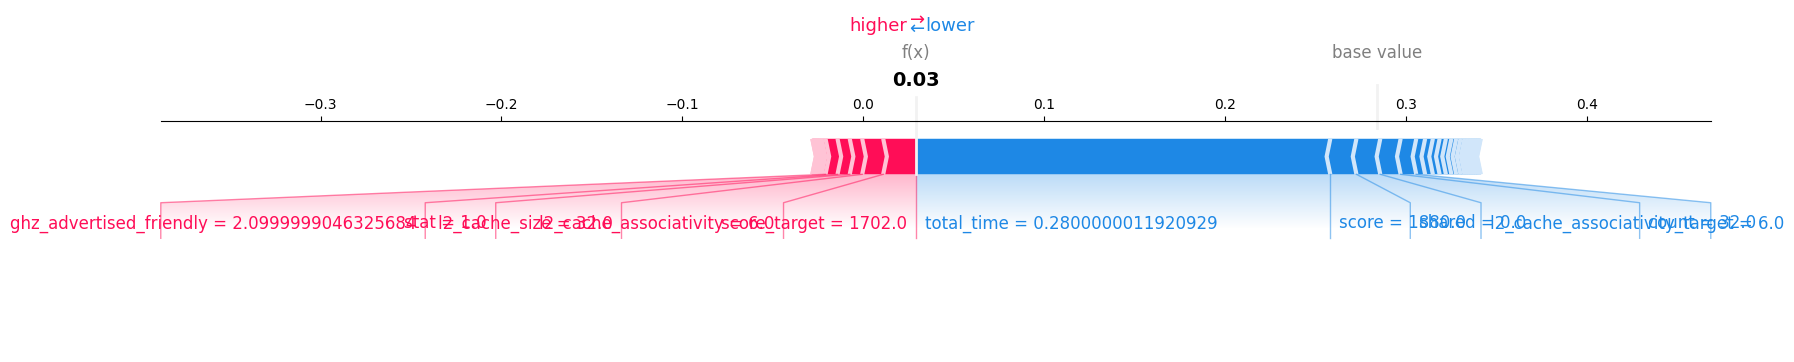

In [29]:
instance = 1
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']} | Error: {abs(y_prediction[instance].item() - test_df_og.iloc[instance]['total_time_target'])}")
shap.force_plot(explainer.expected_value[0], shap_values[instance, :, 0], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 7.009989261627197 | Actual: 6.07 | Error: 0.939989261627197


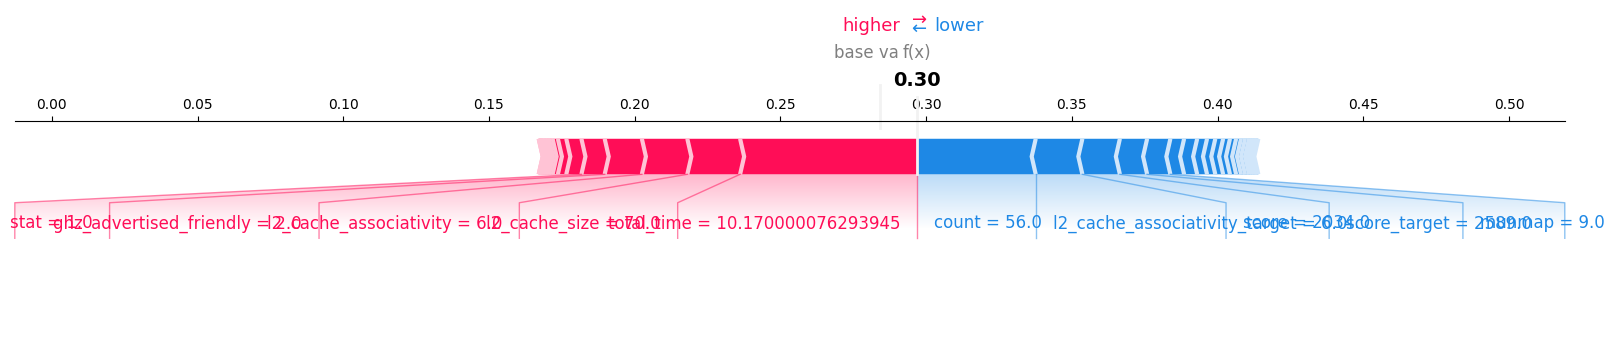

In [34]:
instance = 5
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']} | Error: {abs(y_prediction[instance].item() - test_df_og.iloc[instance]['total_time_target'])}")
shap.force_plot(explainer.expected_value[0], shap_values[instance, :, 0], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 310.98370361328125 | Actual: 269.24 | Error: 41.74370361328124


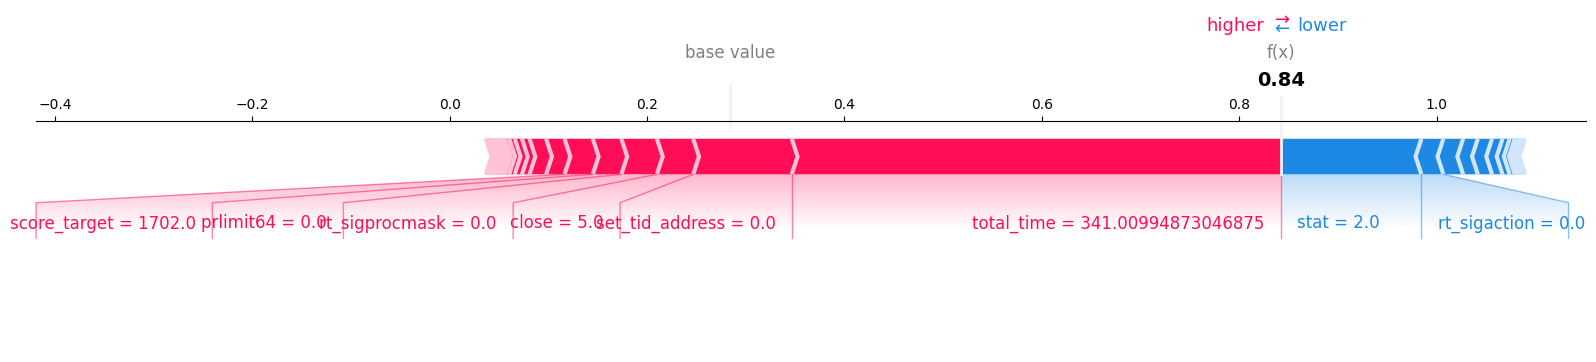

In [33]:
instance = 170
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']} | Error: {abs(y_prediction[instance].item() - test_df_og.iloc[instance]['total_time_target'])}")
shap.force_plot(explainer.expected_value[0], shap_values[instance, :, 0], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

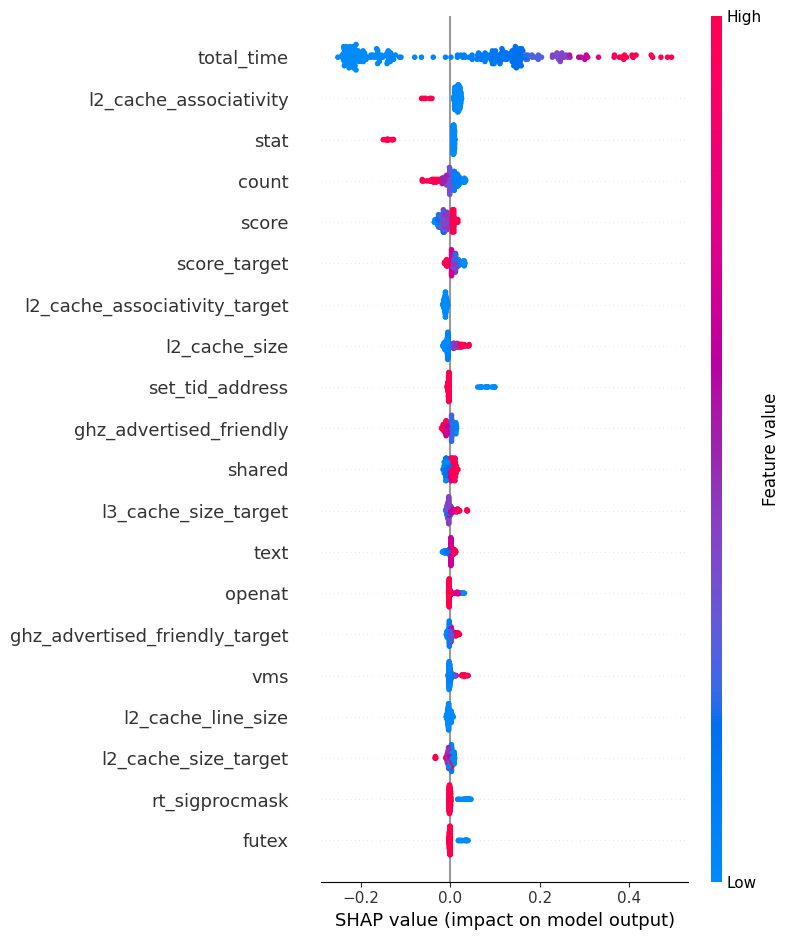

In [26]:
# Sumarize the effects of all the features
shap.summary_plot(shap_values[:,:,0], X_test_non_scaled, feature_names=features)

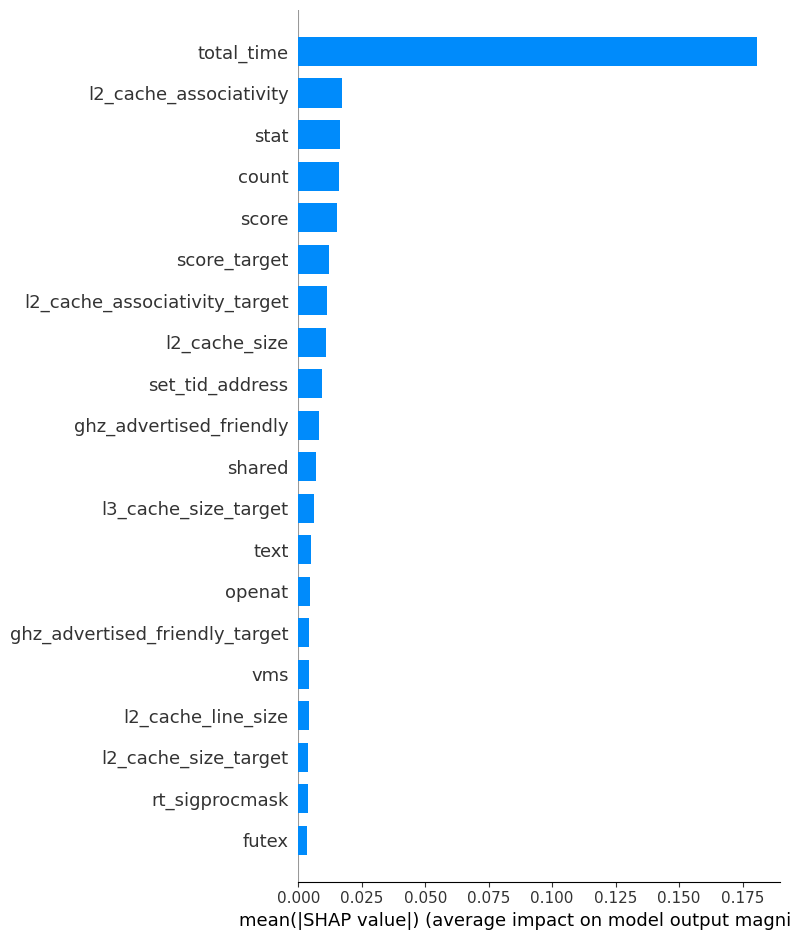

In [27]:
shap.summary_plot(shap_values[:,:,0], X_test_non_scaled, feature_names=features, plot_type='bar')

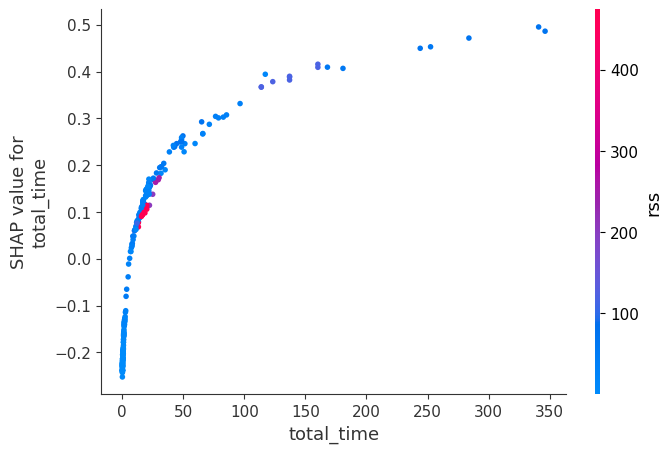

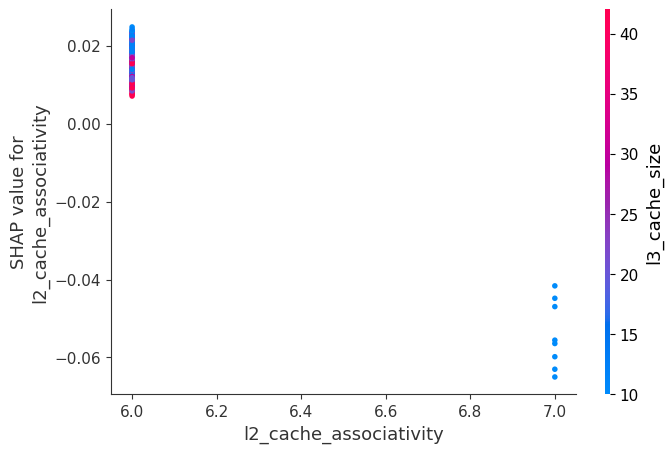

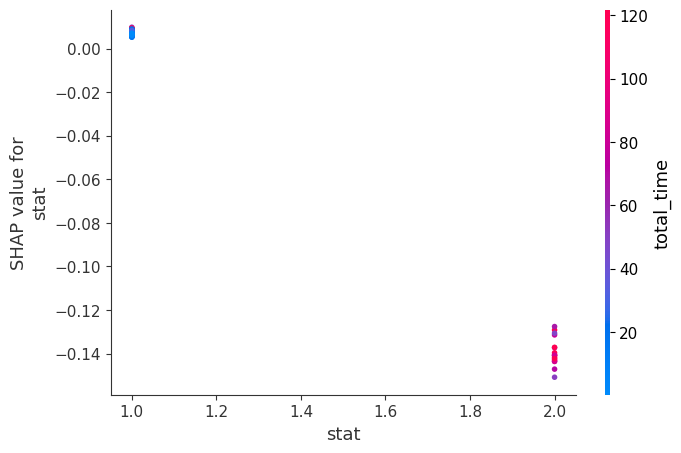

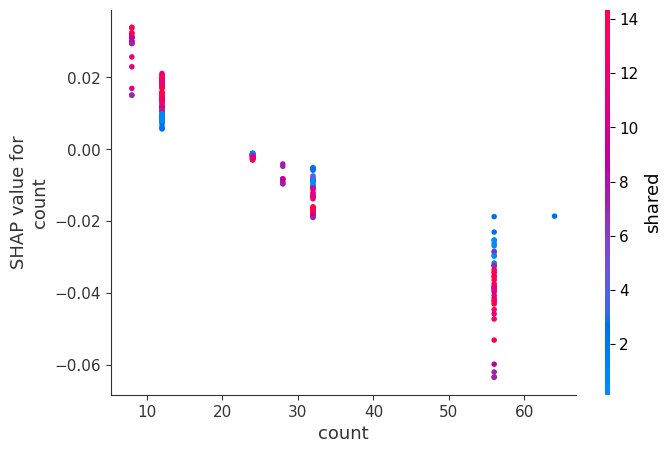

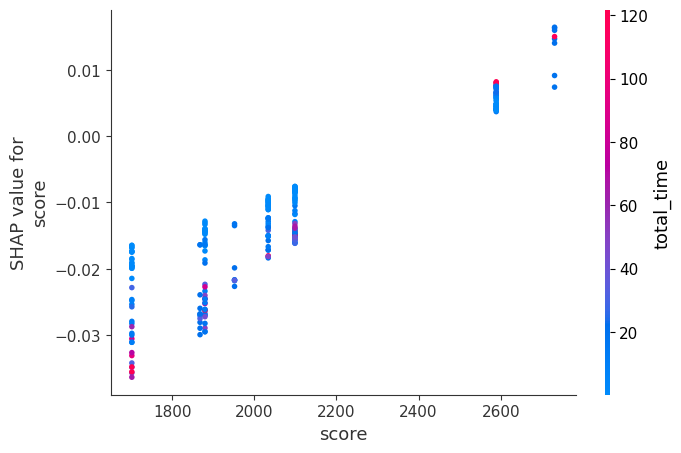

In [28]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the test set)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html
top_inds = np.argsort(-np.sum(np.abs(shap_values[:,:,0]), 0))
for i in range(5):
    # shap.common.approximate_interactions is used to pick what seems to be the strongest interaction 
    shap.dependence_plot(top_inds[i], shap_values[:,:,0], X_test_non_scaled, feature_names=features)